# COVID-19 Literature Clustering

### Goal
Given a large amount of literature and rapidly spreading COVID-19, it is difficult for a scientist to keep up with the research community promptly. Can we cluster similar research articles together to make it easier for health professionals to find relevant research articles? Clustering can be used to create a tool to identify similar articles, given a target article. It can also reduce the number of articles one has to go through as one can focus on a cluster of articles rather than all. 

**Approach**:
<ol>
    <li>Unsupervised Learning task, because we don't have labels for the articles</li>
    <li>Clustering and Dimensionality Reduction task </li>
    <li>See how well labels from K-Means classify</li>
    <li>Use N-Grams with Hash Vectorizer</li>
    <li>Use plain text with Tf-idf</li>
    <li>Use K-Means for clustering</li>
    <li>Use t-SNE for dimensionality reduction</li>
    <li>Use PCA for dimensionality reduction</li>
    <li>There is no continuous flow of data, no need to adjust to changing data, and the data is small enough to fit in memmory: Batch Learning</li>
    <li>Altough, there is no continuous flow of data, our approach has to be scalable as there will be more literature later</li>
</ol>

### Dataset Description

>*In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 29,000 scholarly articles, including over 13,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.*
#### Cite: [COVID-19 Open Research Dataset Challenge (CORD-19) | Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) <br>

**Clustering section of the project (cite):** *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, 2nd Edition, by Aurelien Geron (O'Reilly). Copyright 2019 Kiwisoft S.A.S, 978-1-492-03264-9. Machine Learning Practice. Implimenting this section following the Chapter-9 project on O'REILLY's Hands-On Machine Learning. <br>

## Load the Data
Load the data following the notebook by Ivan Ega Pratama, from Kaggle.
#### Cite: [Dataset Parsing Code | Kaggle, COVID EDA: Initial Exploration Tool](https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import glob
import json

### Loading Metadata

Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [2]:
root_path = 'data/2020-03-13/'
metadata_path = f'{root_path}/all_sources_metadata_2020-03-13.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2002765492,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3003430844,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3006065484,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,177663115,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3006643024,#3242,False


### Fetch All of JSON File Path

Get path to all JSON files:

In [3]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

13202

### Helper: File Reader Class

In [4]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
            # Extend Here
            #
            #
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

8f8eb4f004c2002face0723f2f58cc411954d36e: Bordetella bronchiseptica isolate KM22 has been used in experimental infections of swine as a model of clinical B. bronchiseptica infection and to study host-to-host transmission. The draft genome seq... 20-kb insert library preparation protocol (https://www.pacb.com/wp-content/uploads/ Procedure-Checklist-20-kb-Template-Preparation-Using-BluePippin-Size-Selection -System.pdf). The 20-kb library was s...


### Load the Data into DataFrame

Using the helper function, let's read in the articles into a DataFrame that can be used easily:

In [5]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text'])
df_covid.head()

Processing index: 0 of 13202
Processing index: 1320 of 13202
Processing index: 2640 of 13202
Processing index: 3960 of 13202
Processing index: 5280 of 13202
Processing index: 6600 of 13202
Processing index: 7920 of 13202
Processing index: 9240 of 13202
Processing index: 10560 of 13202
Processing index: 11880 of 13202
Processing index: 13200 of 13202


,paper_id,abstract,body_text
0,8f8eb4f004c2002face0723f2f58cc411954d36e,Bordetella bronchiseptica isolate KM22 has bee...,20-kb insert library preparation protocol (htt...
1,63f7049d200896290b38b38711113054f7ea1b50,,I nfectious diseases have been an ever-present...
2,4df45b8404d9de0b376a8ae3c282a517df36fe51,The influenza A nucleoprotein (NP) is an attra...,The transmission of a pathogenic avian H5N1 vi...
3,e0737ee93afe7b0bf06b1e3f9adf21d541dd10f0,The outbreak of severe acute respiratory syndr...,acute lung injury; inflammatory response; neut...
4,3c3572ba243d61e7631725669c8f88347fdbd5bc,The prevalence of feline herpesvirus-1 (FHV-1)...,Feline herpesvirus type 1 (FHV-1) is the most ...


### Adding the Word Count Column

Adding word count columns for both abstract and body_text can be useful parameters later:

In [6]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid.head()

,paper_id,abstract,body_text,abstract_word_count,body_word_count
0,8f8eb4f004c2002face0723f2f58cc411954d36e,Bordetella bronchiseptica isolate KM22 has bee...,20-kb insert library preparation protocol (htt...,44,345
1,63f7049d200896290b38b38711113054f7ea1b50,,I nfectious diseases have been an ever-present...,0,3427
2,4df45b8404d9de0b376a8ae3c282a517df36fe51,The influenza A nucleoprotein (NP) is an attra...,The transmission of a pathogenic avian H5N1 vi...,200,3592
3,e0737ee93afe7b0bf06b1e3f9adf21d541dd10f0,The outbreak of severe acute respiratory syndr...,acute lung injury; inflammatory response; neut...,255,3047
4,3c3572ba243d61e7631725669c8f88347fdbd5bc,The prevalence of feline herpesvirus-1 (FHV-1)...,Feline herpesvirus type 1 (FHV-1) is the most ...,93,1611


In [7]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13202 entries, 0 to 13201
Data columns (total 5 columns):
paper_id               13202 non-null object
abstract               13202 non-null object
body_text              13202 non-null object
abstract_word_count    13202 non-null int64
body_word_count        13202 non-null int64
dtypes: int64(2), object(3)
memory usage: 515.8+ KB


In [8]:
df_covid.describe(include='all')

,paper_id,abstract,body_text,abstract_word_count,body_word_count
count,13202,13202,13202,13202.000000,13202.000000
unique,13202,11113,13192,NaN,NaN
top,73af6e73949ec28b7c3b13d24a9168e891d7bb23,,"A 54-year-old Korean man living in Wuhan, Chin...",NaN,NaN
freq,1,2073,2,NaN,NaN
mean,NaN,NaN,NaN,210.911604,4259.200273
std,NaN,NaN,NaN,198.086664,4707.945123
min,NaN,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,NaN,112.000000,2477.250000
50%,NaN,NaN,NaN,200.000000,3717.000000
75%,NaN,NaN,NaN,271.000000,5363.750000


### Clean Duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

In [9]:
df_covid.drop_duplicates(['abstract'], inplace=True)
df_covid.describe(include='all')

,paper_id,abstract,body_text,abstract_word_count,body_word_count
count,11113,11113,11113,11113.000000,11113.000000
unique,11113,11113,11113,NaN,NaN
top,73af6e73949ec28b7c3b13d24a9168e891d7bb23,"Samples of blood, kidney and liver were random...",The importance of the translation machinery an...,NaN,NaN
freq,1,1,1,NaN,NaN
mean,NaN,NaN,NaN,250.366778,4465.941780
std,NaN,NaN,NaN,191.639090,4007.811003
min,NaN,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,NaN,162.000000,2806.000000
50%,NaN,NaN,NaN,220.000000,3966.000000
75%,NaN,NaN,NaN,288.000000,5563.000000


## Take a Look at the Data:

In [10]:
df_covid.head()

,paper_id,abstract,body_text,abstract_word_count,body_word_count
0,8f8eb4f004c2002face0723f2f58cc411954d36e,Bordetella bronchiseptica isolate KM22 has bee...,20-kb insert library preparation protocol (htt...,44,345
1,63f7049d200896290b38b38711113054f7ea1b50,,I nfectious diseases have been an ever-present...,0,3427
2,4df45b8404d9de0b376a8ae3c282a517df36fe51,The influenza A nucleoprotein (NP) is an attra...,The transmission of a pathogenic avian H5N1 vi...,200,3592
3,e0737ee93afe7b0bf06b1e3f9adf21d541dd10f0,The outbreak of severe acute respiratory syndr...,acute lung injury; inflammatory response; neut...,255,3047
4,3c3572ba243d61e7631725669c8f88347fdbd5bc,The prevalence of feline herpesvirus-1 (FHV-1)...,Feline herpesvirus type 1 (FHV-1) is the most ...,93,1611


## Data Pre-processing

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's remove punctuation from each text:

In [11]:
import re

df_covid['body_text'] = df_covid['body_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

Convert each text to lower case:

In [12]:
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_covid['body_text'] = df_covid['body_text'].apply(lambda x: lower_case(x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: lower_case(x))

In [13]:
df_covid.head(4)

,paper_id,abstract,body_text,abstract_word_count,body_word_count
0,8f8eb4f004c2002face0723f2f58cc411954d36e,bordetella bronchiseptica isolate km22 has bee...,20kb insert library preparation protocol https...,44,345
1,63f7049d200896290b38b38711113054f7ea1b50,,i nfectious diseases have been an everpresent ...,0,3427
2,4df45b8404d9de0b376a8ae3c282a517df36fe51,the influenza a nucleoprotein np is an attract...,the transmission of a pathogenic avian h5n1 vi...,200,3592
3,e0737ee93afe7b0bf06b1e3f9adf21d541dd10f0,the outbreak of severe acute respiratory syndr...,acute lung injury inflammatory response neutro...,255,3047


## Similar Articles
Now that we have the text cleaned up, we can create our features vector which can be fed into a clustering or dimensionality reduction algorithm. For our first try, we will focus on the text on the body of the articles. Let's grab that:

In [14]:
text = df_covid.drop(["paper_id", "abstract", "abstract_word_count", "body_word_count"], axis=1)

In [15]:
text.head(5)

,body_text
0,20kb insert library preparation protocol https...
1,i nfectious diseases have been an everpresent ...
2,the transmission of a pathogenic avian h5n1 vi...
3,acute lung injury inflammatory response neutro...
4,feline herpesvirus type 1 fhv1 is the most fre...


Let's transform 1D DataFrame into 1D list where each index is an article (instance), so that we can work with words from each instance:

In [16]:
text_arr = text.stack().tolist()
len(text_arr)

11113

### 2-Grams:

Let's create 2D list, where each row is instance and each column is a word. Meaning, we will separate each instance into words:  

In [17]:
words = []
for ii in range(0,len(text)):
    words.append(str(text.iloc[ii]['body_text']).split(" "))

In [18]:
print(words[0][0])

20kb


What we want now is n-grams from the words where n=2 (2-gram). We will still have 2D array where each row is an instance; however, each index in that row going to be a 2-gram:

In [19]:
n_gram_all = []

for word in words:
    # get n-grams for the instance
    n_gram = []
    for i in range(len(word)-2+1):
        n_gram.append("".join(word[i:i+2]))
    n_gram_all.append(n_gram)

In [20]:
n_gram_all[0][0]

'20kbinsert'

### Vectorize:

Now we will use HashVectorizer to create the features vector X. For now, let's limit the feature size to 2**12(4096) to speed up the computation. We might need to increase this later to reduce the collusions and improve the accuracy:

In [21]:
from sklearn.feature_extraction.text import HashingVectorizer

# hash vectorizer instance
hvec = HashingVectorizer(lowercase=False, analyzer=lambda l:l, n_features=2**12)

# features matrix X
X = hvec.fit_transform(n_gram_all)

In [22]:
X.shape

(11113, 4096)

#### Separete Training and Test Set

In [23]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test = train_test_split(X.toarray(), test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 8890
 X_test size: 2223 



### Dimensionality Reduction:
#### t-SNE
Using t-SNE we can reduce our high dimensional features vector into 2 dimensional plane. In the process, t-SNE will keep similar instances together while trying to push different instances far from each other. Resulting 2-D plane can be useful to see which articles cluster near each other:

In [37]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1)
X_embedded = tsne.fit_transform(X_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8890 samples in 2.037s...
[t-SNE] Computed neighbors for 8890 samples in 563.192s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8890
[t-SNE] Computed conditional probabilities for sample 2000 / 8890
[t-SNE] Computed conditional probabilities for sample 3000 / 8890
[t-SNE] Computed conditional probabilities for sample 4000 / 8890
[t-SNE] Computed conditional probabilities for sample 5000 / 8890
[t-SNE] Computed conditional probabilities for sample 6000 / 8890
[t-SNE] Computed conditional probabilities for sample 7000 / 8890
[t-SNE] Computed conditional probabilities for sample 8000 / 8890
[t-SNE] Computed conditional probabilities for sample 8890 / 8890
[t-SNE] Mean sigma: 0.184867
[t-SNE] KL divergence after 250 iterations with early exaggeration: 124.596054
[t-SNE] KL divergence after 1000 iterations: 3.349791


Let's plot the result:

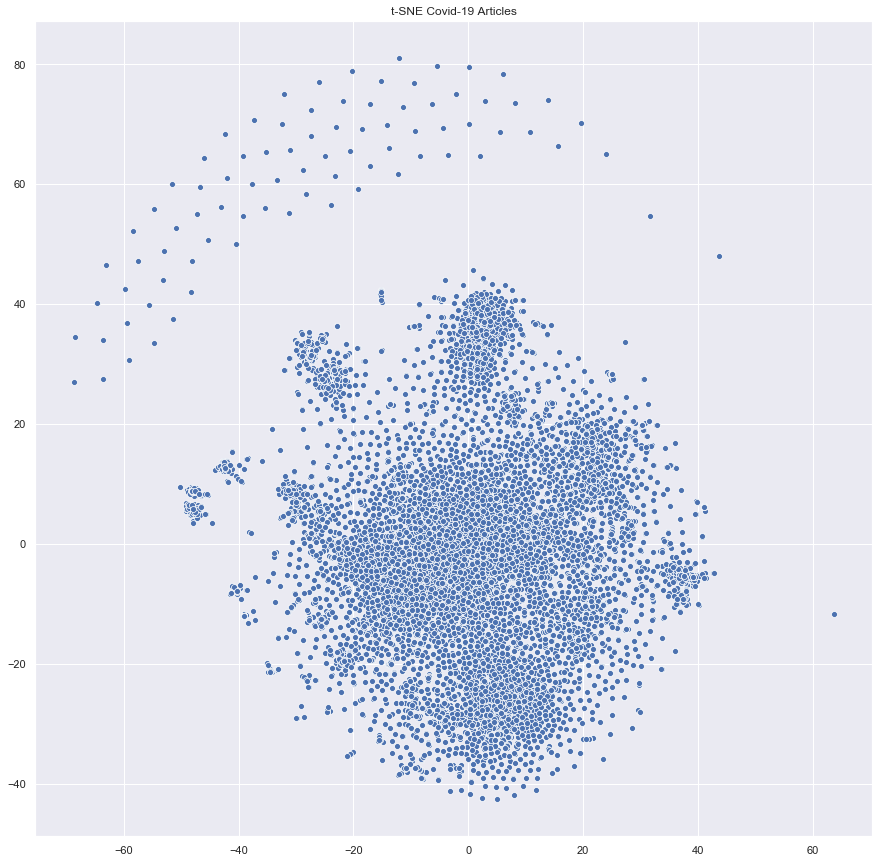

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)

plt.title("t-SNE Covid-19 Articles")
plt.savefig("plots/t-sne_covid19.png")

We can clearly see few clusters forming. This may be a good sign that we are able to cluster similar articles together using 2-grams and HashVectorizer with 2**10 features. However, without labels it is difficult to see the clusters. For now, it looks like a blob of data... Let's try if we can use K-Means to generate our labels. We can later use this information to produce a scatterplot with labels to verify the clusters.

### Unsupervised Learning: Clustering

#### K-Means
Using K-means we will get the labels we need. For now, we will create 10 clusters. I am choosing this arbitrarily. We can change this later.

In [24]:
from sklearn.cluster import KMeans

k = 10
kmeans = KMeans(n_clusters=k, n_jobs=4, verbose=10)
y_pred = kmeans.fit_predict(X_train)

Labels for the training set:

In [35]:
y_train = y_pred

Labels for the test set:

In [49]:
y_test = kmeans.predict(X_test)

Now that we have the labels, let's plot the t-SNE. scatterplot again and see if we have any obvious clusters:

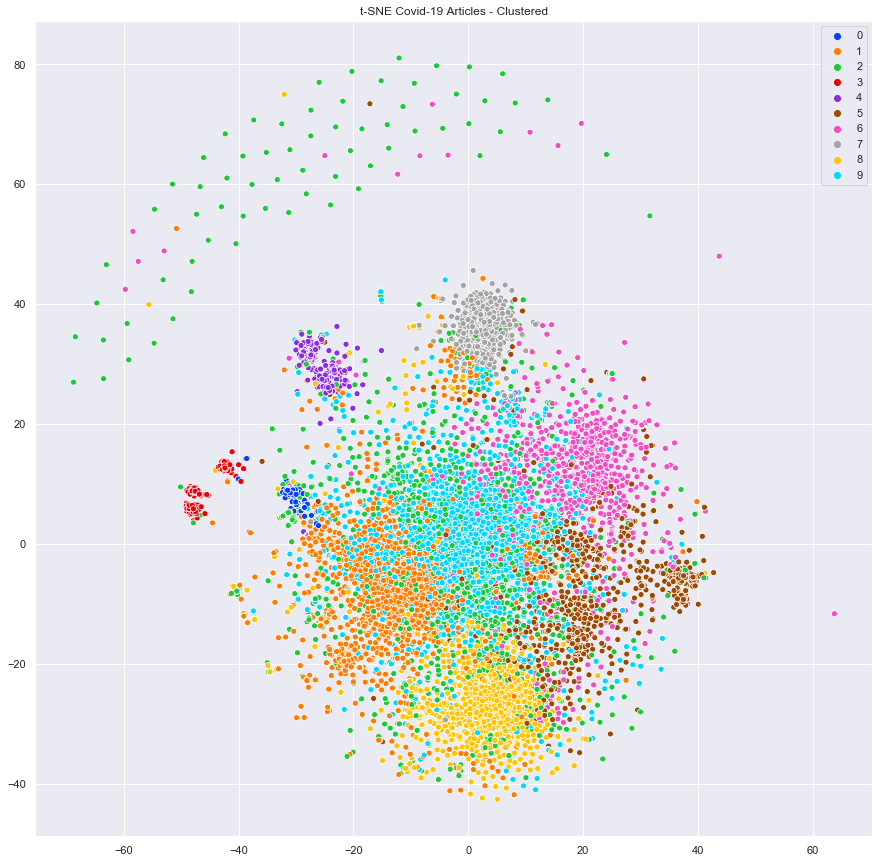

In [45]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
plt.savefig("plots/t-sne_covid19_label.png")

That looks pretty promising. It can be seen that articles from the same cluster are near each other, forming groups. There are still overlaps. So we will have to see if we can improve this by changing the cluster size, using another clustering algorithm, or different feature size. We can also consider not using 2-grams, or HashVectorizer. We can try 3-grams, 4-grams, or plain text as our instances and vectorize them using either HashVectorizer, Tf-idfVectorizer, or Burrows Wheeler Transform Distance. <br>

Before we try another method for clustering, we want to see how well it will classify using the labels we just created using K-Means.

## Classify

### Helper Function:

In [128]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='micro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='micro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='micro')) * 100), "%")

### Random Forest

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# random forest classifier instance
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)

# cross validation on the training set 
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the mean of the cross validation scores
print("Accuracy: ", '{:,.3f}'.format(float(forest_scores.mean()) * 100), "%")

Accuracy:  71.260 %


In [52]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score

# cross validate predict on the training set
forest_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3, n_jobs=4)

# print precision and recall scores
print("Precision: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred, average='macro')) * 100), "%")
print("   Recall: ", '{:,.3f}'.format(float(recall_score(y_train, forest_train_pred, average='macro')) * 100), "%")

Precision:  83.864 %
   Recall:  67.363 %


In [56]:
# first train the model
forest_clf.fit(X_train, y_train)

# make predictions on the test set
forest_pred = forest_clf.predict(X_test)

In [59]:
# print out the classification report
classification_report("Random Forest Classifier Report (Test Set)", y_test, forest_pred)

Random Forest Classifier Report (Test Set) :

Accuracy Score:  73.234 %
     Precision:  84.907 %
        Recall:  70.707 %
      F1 score:  73.255 %


It looks like it doesn't overfit, which is good news. But results can be better than ~70-80%. So we might want to come back to this later again to see if we can improve it.  

## Tf-idf with Plain Text
Let's see if we will be able to get better clusters using plain text as instances rather than 2-grams and vectorize it using Tf-idf.

### Vectorize

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2**12)
X = vectorizer.fit_transform(text_arr)

In [88]:
X.shape

(11113, 4096)

### Separete Training and Test Set

In [89]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test = train_test_split(X.toarray(), test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print(" X_test size:", len(X_test), "\n")

X_train size: 8890
 X_test size: 2223 



### K-Means

Again, let's try to get our labels. We will choose 10 clusters again.

In [92]:
k = 10
kmeans = KMeans(n_clusters=k, n_jobs=4, verbose=10)
y_pred = kmeans.fit_predict(X_train)

Get the training set labels:

In [93]:
y_train = y_pred

Get the test set labels:

In [94]:
y_test = kmeans.predict(X_test)

### Dimensionality Reduction (t-SNE)

Let's reduce the dimensionality using t-SNE again:

In [91]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1)
X_embedded = tsne.fit_transform(X_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8890 samples in 2.341s...
[t-SNE] Computed neighbors for 8890 samples in 560.480s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8890
[t-SNE] Computed conditional probabilities for sample 2000 / 8890
[t-SNE] Computed conditional probabilities for sample 3000 / 8890
[t-SNE] Computed conditional probabilities for sample 4000 / 8890
[t-SNE] Computed conditional probabilities for sample 5000 / 8890
[t-SNE] Computed conditional probabilities for sample 6000 / 8890
[t-SNE] Computed conditional probabilities for sample 7000 / 8890
[t-SNE] Computed conditional probabilities for sample 8000 / 8890
[t-SNE] Computed conditional probabilities for sample 8890 / 8890
[t-SNE] Mean sigma: 0.213603
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.313774
[t-SNE] KL divergence after 1000 iterations: 2.192113


### Plot t-SNE

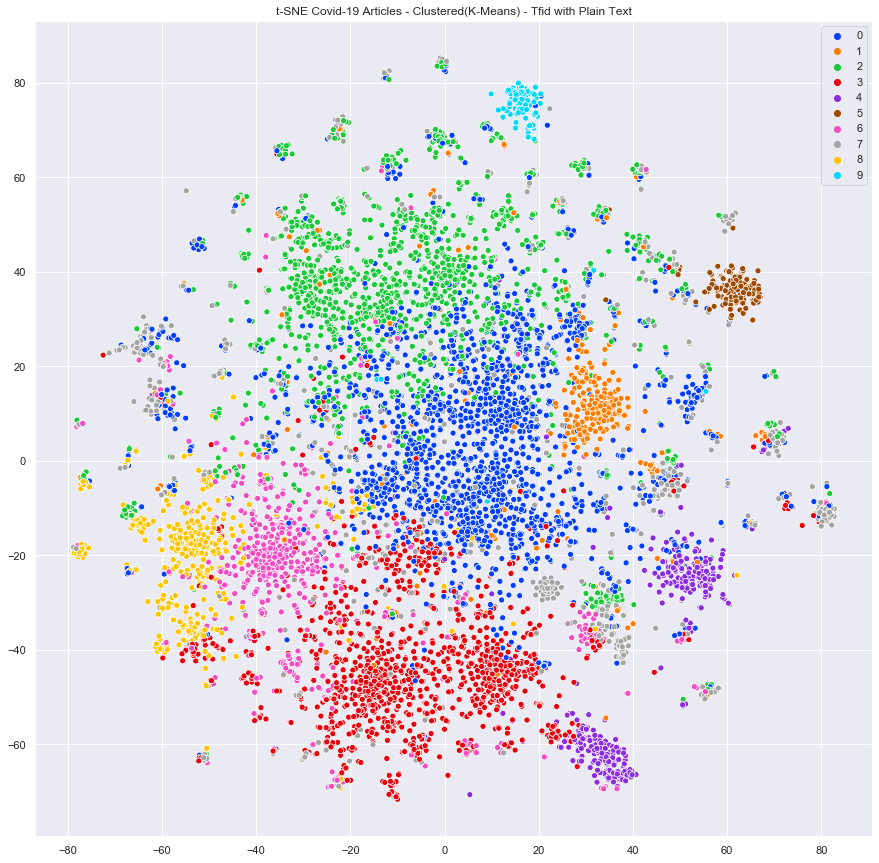

In [103]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered(K-Means) - Tf-idf with Plain Text")
plt.savefig("plots/t-sne_covid19_label_TFID.png")

This time we are able to see the clusters more clearly. There are clusters that further apart from each other. I can also start to see that there is possibly more than 10 clusters we need to identify using k-means.

### Dimensionality Reduction (PCA)

In [107]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train)

### Plot PCA

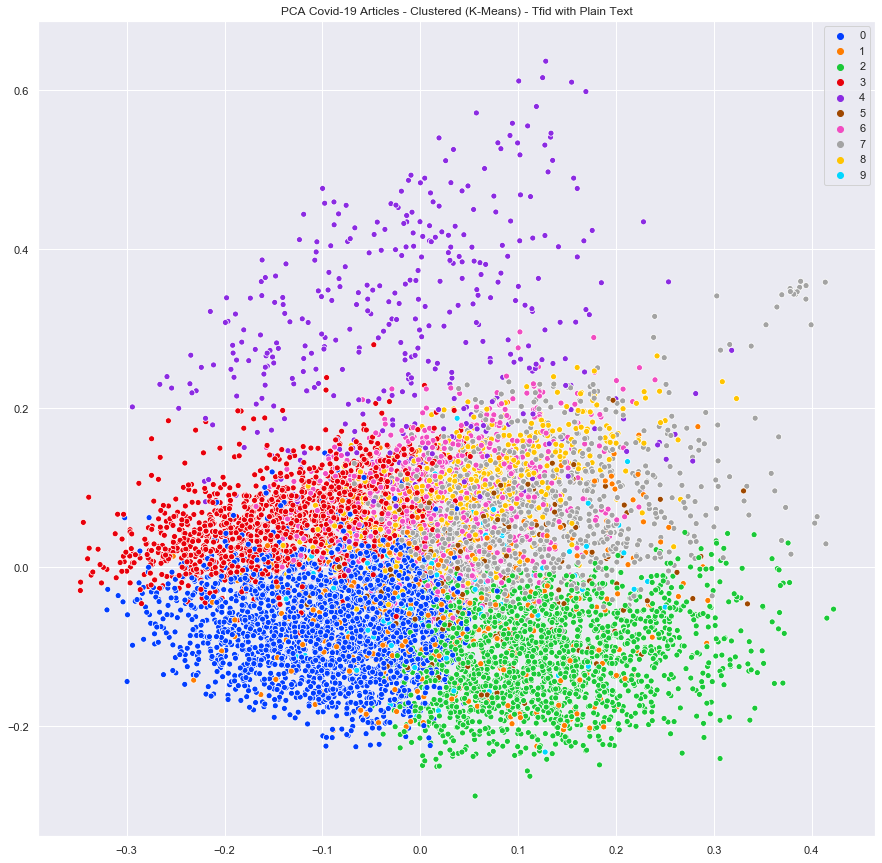

In [108]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(pca_result[:,0], pca_result[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("PCA Covid-19 Articles - Clustered (K-Means) - Tf-idf with Plain Text")
plt.savefig("plots/pca_covid19_label_TFID.png")

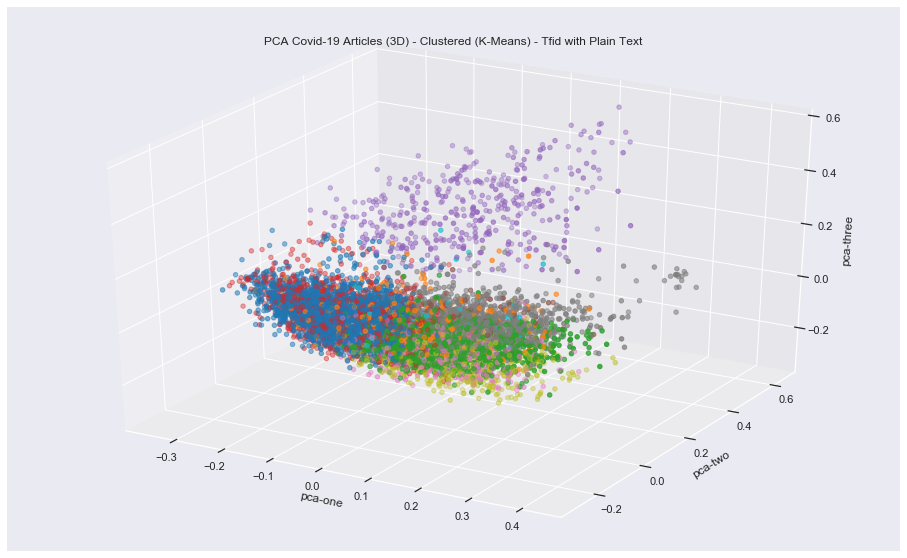

In [117]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=y_pred, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.title("PCA Covid-19 Articles (3D) - Clustered (K-Means) - Tf-idf with Plain Text")
plt.savefig("plots/pca_covid19_label_TFID_3d.png")
plt.show()

### More Clusters?
On our previous plot we could see that there is more clusters than only 10. Let's try to label them:

In [138]:
k = 25
kmeans = KMeans(n_clusters=k, n_jobs=4, verbose=10)
y_pred = kmeans.fit_predict(X_train)

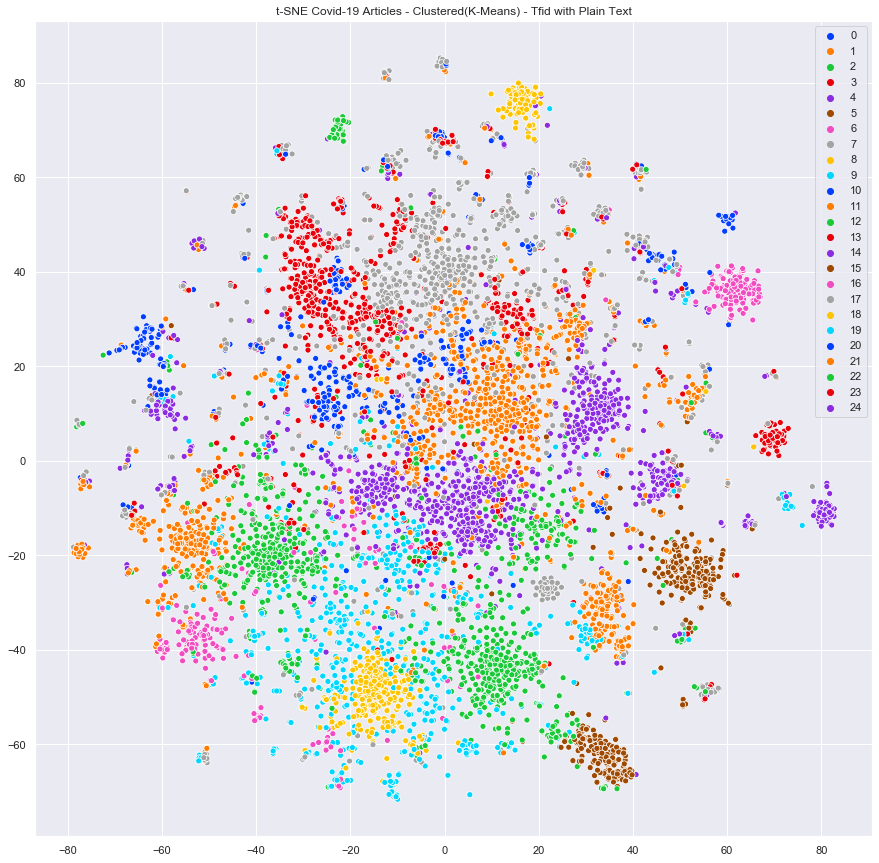

In [139]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered(K-Means) - Tf-idf with Plain Text")
plt.savefig("plots/t-sne_covid19_20label_TFID.png")